**Навигация по уроку**
1. [Механизм внимания](https://colab.research.google.com/drive/1VWigPMuZVLXJa7Ys-WCSKAZcg4ZUhjny)
2. [Англо-русский переводчик c механизмом внимания](https://colab.research.google.com/drive/1iqWK_AfEG3GtruW9RN_PthHvn04QSbhg)
3. [Переводчик с нейро-сетевым механизмом внимания](https://colab.research.google.com/drive/1kXBDTWUCoiXFSpOaE2562X5n92Ehdpfg)
4. Домашняя работа

В домашней работе вам необходимо выполнить одно из трёх заданий на выбор:

**Задание 1. На 3 балла:**

1. Используя любой публичный датасет с диалогами, создайте чат-бот seq2seq с механизмом внимания. Задача обучить сеть по входной последовательности вопросов генерировать ответы.

2. Отобразите график внимания.

3. Если возникнет проблема с поиском датасета с диалогами, то можно использовать этот: https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt

**Задание 2. На 4 балла:**

Необходимо выполнить 1 задание со следующими изменениями:
1. Разработать класс внимания, который будет включать механизм внимания Богданова и 3 варианта механизма внимания Luong:

$$
f(h_{t-1}, e_{t'}) =
\begin{cases}
h_{t-1}^T e_{t'} & \text{точечное внимание}\\
h_{t-1}^T W e_{t'} & \text{общее внимание}\\
v^T \tanh \left(W [h_{t-1}, e_{t'}]\right) & \text{объединенное внимание}\\
\end{cases}
$$

Выбор используемого механизма внимания должен происходить при инициализации класса.

**Задание 3. На 5 балла:**

*Задание на 5 баллов самостоятельное и должно выполняться без помощи куратора. Выполнение задания на 5 баллов характеризует вас, как сильного специалиста, способного решать сложные задачи, объединяющие знания из нескольких уроков, а также подразумевают самостоятельный поиск и анализ информации.*

В данном задании вы должны разработать нейросеть seq2seq с механизмом внимания, которая преобразует изображения в формат LaTeX (математические формулы).





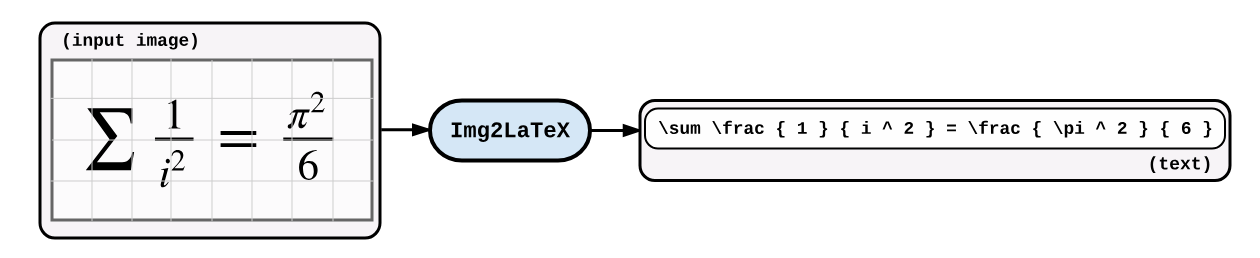

Для выполнения задания необходимо изучить [статью](https://arxiv.org/pdf/1609.04938).

Использовать датасет [im2latex](https://zenodo.org/records/56198#.V2p0KTXT6eA).

# Изучение Coarse-to-Fine Attention

Статья **"Image-to-Markup Generation with Coarse-to-Fine Attention"** (Yuntian Deng et al., 2016) предлагает нейросетевую модель encoder-decoder для преобразования изображений в разметку (например, LaTeX-код для математических формул). Вот её основные аспекты:

## Задача и мотивация
**Цель:** Преобразование изображений (например, математических формул) в структурированную разметку (LaTeX). Это сложная задача OCR из-за вариативности символов, их пространственных отношений и контекстной зависимости.

**Проблема:** Стандартные подходы (например, на основе CTC) плохо справляются с нестандартными OCR-задачами, где требуется точное восстановление структуры (например, вложенные математические выражения).

## Архитектура модели
Модель состоит из нескольких компонентов, объединенных в структуру encoder-decoder с механизмом внимания:

- Сверточный нейросетевой encoder (CNN):

    Извлекает визуальные features из изображения. Используется многослойный CNN без полносвязных слоев чтобы сохранить пространственную информацию.

- Row encoder (RNN):

    Обрабатывает features от CNN построчно с помощью RNN (например, LSTM) для учёта пространственной структуры и контекста.

- Decoder с coarse-to-fine attention:

    - **Coarse attention:** Сначала выбирает широкую область (support region) изображения для фокусировки, уменьшая вычислительную сложность.

    - **Fine attention:** Затем применяет точное внимание внутри выбранной области для детального анализа символов.

    - Decoder генерирует последовательность токенов разметки (LaTeX) на основе контекста, обновляемого механизмом внимания

## Сравнение с базовыми методами:

Модель превзошла классические OCR-системы для математических формул (например, на рендерных данных) и показала хорошее обобщение на рукописных данных.

**Эффективность:** Подход на основе внимания оказался более точным для нестандартных OCR задач в сравнении с CTC - Connectionist Temporal Classification (Связностное Временное Классифицирование).

Пример дерева разметки
Для формулы \int_0^3 \int_1^4 (6-3)(4-2) \, dx \, dy = 12 $$\int_0^3 \int_1^4 (6-3)(4-2) \, dx \, dy = 12$$ модель строит древовидную структуру, где каждый узел представляет символ и его позицию (например, интегралы, пределы, переменные). Это иллюстрирует способность модели обрабатывать сложные иерархии.

## Ззначимость
- Работа демонстрирует, что attention-based подходы эффективны для задач image-to-markup, особенно когда требуется сохранение структурной целостности (например, в математике, химических формулах).

- Coarse-to-fine attention уменьшает вычислительную сложность и позволяет модели масштабироваться для длинных последовательностей.


# Создание модели с Coarse-to-Fine Attention

## Импорты

In [ ]:
!pip install sentencepiece chardet
!apt-get -y install nodejs npm
!npm install katex
!git clone https://github.com/harvardnlp/im2markup.git

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from tqdm import tqdm
import sentencepiece as spm
from typing import List, Tuple
import chardet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузка датасета с Zenodo
os.system('mkdir -p data')
os.chdir('data')
os.system('wget https://zenodo.org/records/56198/files/formula_images.tar.gz')
os.system('wget https://zenodo.org/records/56198/files/im2latex_formulas.lst')
os.system('wget https://zenodo.org/records/56198/files/im2latex_test.lst')
os.system('wget https://zenodo.org/records/56198/files/im2latex_train.lst')
os.system('wget https://zenodo.org/records/56198/files/im2latex_validate.lst')
os.system('tar -zxvf formula_images.tar.gz')
os.chdir('..')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gyp javascript-common libc-ares2 libjs-events libjs-highlight.js
  libjs-inherits libjs-is-typedarray libjs-psl libjs-source-map
  libjs-sprintf-js libjs-typedarray-to-buffer libnode-dev libnode72
  libnotify-bin libnotify4 libuv1-dev node-abab node-abbrev node-agent-base
  node-ansi-regex node-ansi-styles node-ansistyles node-aproba node-archy
  node-are-we-there-yet node-argparse node-arrify node-asap node-asynckit
  node-balanced-match node-brace-expansion node-builtins node-cacache
  node-chalk node-chownr node-clean-yaml-object node-cli-table node-clone
  node-color-convert node-color-name node-colors node-columnify
  node-combined-stream node-commander node-console-control-strings
  node-copy-concurrently node-core-util-is node-coveralls node-cssom
  node-cssstyle node-debug node-decompress-response node-defaults
  node-delayed-st

## Нормализация формул

Для улучшения обработки токенизатором рекомендуется нормализовать формулы. Нашел скрипт для этого на Git как раз в ветке с обработкой изображений в LaTeX, но т.к. цель собрать модель самому, то воспользуюсь только скриптом нормализации.

In [ ]:
# Normalize formulas
os.system('python im2markup/scripts/preprocessing/preprocess_formulas.py --mode normalize --input-file data/im2latex_formulas.lst --output-file data/im2latex_formulas.norm.lst')


256

## Предобработка изображений

In [ ]:
# Preprocess images: crop and downsample
def preprocess_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    for file in tqdm(files):
        input_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file)
        try:
            image = Image.open(input_path)
            bbox = image.getbbox()
            if bbox:
                cropped = image.crop(bbox).convert('L')
                w, h = cropped.size
                resized = cropped.resize((w // 2, h // 2), Image.LANCZOS)
                resized.save(output_path)
        except Exception as e:
            print(f"Error processing {file}: {e}")

preprocess_images('data/formula_images', 'data/images_processed')

  0%|          | 0/103536 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 103536/103536 [19:36<00:00, 87.98it/s]


## Токенизатор BBPE

Воспользуемся Byte-level BPE токенизатором, чтобы у нас не было неизвестных символов и не нарушалась логика формул

In [ ]:
# Train BPE tokenizer
spm.SentencePieceTrainer.train(
    input='data/im2latex_formulas.norm.lst',
    model_prefix='latex_bpe',
    vocab_size=8000,  # компромисс между скоростью и качеством
    character_coverage=1.0,
    model_type='bpe',
    byte_fallback=True,  # byte-level
    user_defined_symbols='<sos>,<eos>,<pad>',
    split_digits=True    # Разделять цифры и символы
)

sp = spm.SentencePieceProcessor(model_file='latex_bpe.model')

vocab_size = sp.get_piece_size()
pad_id = sp.piece_to_id('<pad>')
sos_id = sp.piece_to_id('<sos>')
eos_id = sp.piece_to_id('<eos>')
unk_id = sp.unk_id()

### Проверка на формуле

In [ ]:
test_formula = r"\oint_{\partial\Sigma} \mathbf{B} \cdot d\boldsymbol{\ell} = \mu_0 \iint_{\Sigma} \mathbf{J} \cdot d\mathbf{S} + \mu_0 \varepsilon_0 \frac{d}{dt} \iint_{\Sigma} \mathbf{E} \cdot d\mathbf{S} + \frac{\hbar^2}{2m} \nabla^2 \Psi + V(\mathbf{r})\Psi = i\hbar \frac{\partial\Psi}{\partial t} + \bigotimes_{i=1}^n \widehat{\alpha_i} \widetilde{\beta_i} \approx \sum_{k=1}^\infty \prod_{j=1}^m \xi_{kj} \binom{n}{k} \varnothing \aleph"

# Токенизация формулы
pieces = sp.encode_as_pieces(test_formula)
tokens = sp.encode_as_ids(test_formula)

# Подсчет UNK-токенов
unk_count = sum(1 for piece in pieces if piece == '<unk>' or '▁<unk>' in piece)
unk_percentage = unk_count / len(pieces) * 100

print(f"Общее количество токенов: {len(pieces)}")
print(f"UNK-токенов: {unk_count}")
print(f"Процент UNK: {unk_percentage:.2f}%")
print("\nДетализация токенов:")
for i, (piece, token_id) in enumerate(zip(pieces, tokens)):
    print(f"{i:3d}: '{piece}' (ID: {token_id})")

Общее количество токенов: 183
UNK-токенов: 0
Процент UNK: 0.00%

Детализация токенов:
  0: '▁\' (ID: 262)
  1: 'oint' (ID: 819)
  2: '_{\' (ID: 286)
  3: 'partial' (ID: 305)
  4: '\' (ID: 15904)
  5: 'Sigma' (ID: 566)
  6: '}' (ID: 15907)
  7: '▁\' (ID: 262)
  8: 'mathbf' (ID: 654)
  9: '{' (ID: 15906)
 10: 'B' (ID: 15957)
 11: '}' (ID: 15907)
 12: '▁\' (ID: 262)
 13: 'cdot' (ID: 474)
 14: '▁d' (ID: 335)
 15: '\' (ID: 15904)
 16: 'bol' (ID: 8035)
 17: 'ds' (ID: 742)
 18: 'y' (ID: 15942)
 19: 'mb' (ID: 307)
 20: 'ol' (ID: 680)
 21: '{\' (ID: 263)
 22: 'ell' (ID: 567)
 23: '}' (ID: 15907)
 24: '▁=' (ID: 282)
 25: '▁\' (ID: 262)
 26: 'mu' (ID: 291)
 27: '_' (ID: 15914)
 28: '0' (ID: 15937)
 29: '▁\' (ID: 262)
 30: 'i' (ID: 15911)
 31: 'int' (ID: 339)
 32: '_{\' (ID: 286)
 33: 'Sigma' (ID: 566)
 34: '}' (ID: 15907)
 35: '▁\' (ID: 262)
 36: 'mathbf' (ID: 654)
 37: '{' (ID: 15906)
 38: 'J' (ID: 15976)
 39: '}' (ID: 15907)
 40: '▁\' (ID: 262)
 41: 'cdot' (ID: 474)
 42: '▁d' (ID: 335)
 43: '\'

$$\oint_{\partial\Sigma} \mathbf{B} \cdot d\boldsymbol{\ell} = \mu_0 \iint_{\Sigma} \mathbf{J} \cdot d\mathbf{S} + \mu_0 \varepsilon_0 \frac{d}{dt} \iint_{\Sigma} \mathbf{E} \cdot d\mathbf{S} + \frac{\hbar^2}{2m} \nabla^2 \Psi + V(\mathbf{r})\Psi = i\hbar \frac{\partial\Psi}{\partial t} + \bigotimes_{i=1}^n \widehat{\alpha_i} \widetilde{\beta_i} \approx \sum_{k=1}^\infty \prod_{j=1}^m \xi_{kj} \binom{n}{k} \varnothing \aleph$$


## Подготовка датасета

In [ ]:
def load_text_file(path: str):
    """
    Загружает текстовый файл с автоматическим определением кодировки.
    Возвращает список строк без символов перевода строки.
    """
    try:
        with open(path, 'r', encoding='utf-8', newline='\n') as f:
            return [line.rstrip('\n') for line in f]
    except UnicodeDecodeError:
        with open(path, 'rb') as f:
            raw_data = f.read()
        result = chardet.detect(raw_data)
        encoding = result['encoding']
        print(f"[INFO] Файл {path} открыт в кодировке: {encoding}")
        with open(path, 'r', encoding=encoding, newline='\n', errors='replace') as f:
            return [line.rstrip('\n') for line in f]

# фильтруем списки, чтобы отсеять слишком большие или маленькие изображения
def create_filter_list(
        data_path,
        output_path,
        image_dir,
        label_path,
        filter_on=True,
        max_width=500,
        max_height=160,
        min_width=32,
        min_height=32,
        max_tokens=150):
    lines = load_text_file(data_path)
    formulas = load_text_file(label_path)
    filtered = []
    for line in tqdm(lines):
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 2:
            continue
        if len(parts) == 2:
            idx, img = parts
            rtype = 'default'
        else:
            idx, img, rtype = parts[:3]
        label_idx = int(idx)
        img_name = img + '.png'
        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path):
            continue
        formula = formulas[label_idx].strip()
        if not formula:
            continue
        tokens = sp.encode_as_pieces(formula)
        if len(tokens) > max_tokens - 2:
            continue
        if filter_on:
            image = Image.open(img_path)
            w, h = image.size
            if w > max_width or h > max_height:
                continue
            if w < min_width or h < min_height:
                continue
        filtered.append(line)
    with open(output_path, 'w') as f:
        for l in filtered:
            f.write(l + '\n')

create_filter_list('data/im2latex_train.lst', 'data/train_filter.lst', 'data/images_processed', 'data/im2latex_formulas.norm.lst', filter_on=True)
create_filter_list('data/im2latex_validate.lst', 'data/validate_filter.lst', 'data/images_processed', 'data/im2latex_formulas.norm.lst', filter_on=True)
create_filter_list('data/im2latex_test.lst', 'data/test_filter.lst', 'data/images_processed', 'data/im2latex_formulas.norm.lst', filter_on=False)

formulas_path = 'data/im2latex_formulas.norm.lst'
FORMULAS = load_text_file(formulas_path)

train_lst = 'data/train_filter.lst'
val_lst = 'data/validate_filter.lst'
test_lst = 'data/test_filter.lst'

[INFO] Файл data/im2latex_formulas.norm.lst открыт в кодировке: Windows-1252


100%|██████████| 83884/83884 [00:13<00:00, 6352.02it/s]


[INFO] Файл data/im2latex_formulas.norm.lst открыт в кодировке: Windows-1252


100%|██████████| 9320/9320 [00:01<00:00, 6174.58it/s]


[INFO] Файл data/im2latex_formulas.norm.lst открыт в кодировке: Windows-1252


100%|██████████| 10355/10355 [00:00<00:00, 14855.77it/s]


[INFO] Файл data/im2latex_formulas.norm.lst открыт в кодировке: Windows-1252


In [ ]:
# Чтение списка изображений для сплита (train/val/test)
def read_split_list(path: str) -> List[Tuple[int, str, str]]:
    lines = load_text_file(path)
    items = []
    for line in lines:
        line = line.strip()
        if not line:  # Пропуск пустых строк
            continue
        parts = line.split()
        if len(parts) < 3:
            if len(parts) == 2:
                idx, img = parts
                rtype = 'default'
            else:
                continue
        else:
            idx, img, rtype = parts[:3]
        items.append((int(idx), img + '.png', rtype))
    return items

TRAIN_ITEMS = read_split_list(train_lst)
VAL_ITEMS = read_split_list(val_lst)
TEST_ITEMS = read_split_list(test_lst)

In [ ]:
print("Строк в im2latex_train.lst:", len(load_text_file('data/im2latex_train.lst')))
print("Строк в im2latex_formulas.norm.lst:", len(load_text_file('data/im2latex_formulas.norm.lst')))
print("Строк в train_filter.lst:", len(load_text_file('data/train_filter.lst')))

Строк в im2latex_train.lst: 83884
[INFO] Файл data/im2latex_formulas.norm.lst открыт в кодировке: Windows-1252
Строк в im2latex_formulas.norm.lst: 103559
Строк в train_filter.lst: 78140


In [ ]:
load_text_file('data/im2latex_train.lst')[1]

'2 66667cee5b basic'

In [ ]:
import os
sample_line = "66667cee5b"
parts = sample_line.split()
img_name = parts[0] + '.png'
img_path = os.path.join('data/images_processed', img_name)
print(f"Exists: {os.path.exists(img_path)}, Path: {img_path}")

Exists: True, Path: data/images_processed/66667cee5b.png


In [ ]:
len(TRAIN_ITEMS)

43239

In [ ]:
# сортируем по размеру
def get_image_area(item, img_dir):
    _, img_name, _ = item
    img_path = os.path.join(img_dir, img_name)
    image = Image.open(img_path)
    w, h = image.size
    return w * h

img_dir = 'data/images_processed'
TRAIN_ITEMS = sorted(TRAIN_ITEMS, key=lambda x: get_image_area(x, img_dir))

In [ ]:
len(TRAIN_ITEMS)

43239

### Собираем датасет

In [ ]:
# Dataset
class Im2LatexDataset(Dataset):
    def __init__(self, items, formulas, img_dir, max_len=150):
        self.data = items  # list of (label_idx, img_name, rtype)
        self.formulas = formulas
        self.img_dir = img_dir
        self.max_len = max_len
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label_idx, img_name, _ = self.data[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')
        image = self.transform(image)
        formula = self.formulas[label_idx]
        token_ids = sp.encode_as_ids(formula)
        token_ids = [sos_id] + token_ids + [eos_id]
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
        token_ids += [pad_id] * (self.max_len + 1 - len(token_ids))
        target = torch.LongTensor(token_ids)
        return image, target

def collate_fn(batch):
    images, targets = zip(*batch)
    max_h = max(img.size(1) for img in images)
    max_w = max(img.size(2) for img in images)
    padded_images = []
    for img in images:
        ph = max_h - img.size(1)
        pw = max_w - img.size(2)
        padded = F.pad(img, (0, pw, 0, ph), value=1)  # pad with white
        padded_images.append(padded)
    images = torch.stack(padded_images)
    targets = torch.stack(targets)
    return images, targets

In [ ]:
train_dataset = Im2LatexDataset(TRAIN_ITEMS, FORMULAS, img_dir, max_len=150)
val_dataset = Im2LatexDataset(VAL_ITEMS, FORMULAS, img_dir, max_len=150)
test_dataset = Im2LatexDataset(TEST_ITEMS, FORMULAS, img_dir, max_len=150)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False, collate_fn=collate_fn)

In [ ]:
len(train_dataset)

43239

## Модель

In [ ]:
# Энкодер
class Encoder(nn.Module):
    def __init__(self, hidden=512):
        super().__init__()
        # Размер скрытого состояния LSTM
        self.hidden = hidden
        # Сверточная нейронная сеть для извлечения признаков
        self.cnn = nn.Sequential(
            # 1 канал -> 64, ядро 3x3 с padding=1
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2), # Уменьшение размера в 2 раза
            # 64 -> 128
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 128 -> 256
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 256 -> 512
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            # уменьшает только ширину
            nn.MaxPool2d((2, 1), (2, 1)),
            # Финальный сверточный слой: 512 -> 512, ядро 2x2 без padding
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU()
        )
        # LSTM для обработки последовательности по строкам признаков
        # Принимает вход размером 512, выдает скрытые состояния размером 512
        self.row_lstm = nn.LSTM(512, 512, num_layers=1, bidirectional=False, batch_first=True)

    def forward(self, x):
        feat = self.cnn(x)
        # Получаем размерности выходного тензора CNN
        b, d, h, w = feat.size()

        # Изменяем порядок размерностей:
        # [batch, channels, height, width] -> [batch, height, width, channels]
        feat = feat.permute(0, 2, 3, 1)

        # Преобразуем тензор для LSTM: объединяем batch и height, чтобы обрабатывать строки как последовательности
        feat = feat.contiguous().view(b * h, w, d)

        # Применяем LSTM к последовательностям (каждая строка обрабатывается независимо)
        feat, _ = self.row_lstm(feat)

        # Восстанавливаем оригинальную структуру: разделяем batch и height
        feat = feat.view(b, h, w, self.hidden)
        return feat

# Слой внимания
class CoarseFineAttention(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        # Линейные преобразования для запроса и значений
        self.w1 = nn.Linear(hidden, hidden, bias=False)  # Преобразование запроса
        self.w2 = nn.Linear(hidden, hidden, bias=False)  # Преобразование значений
        self.v = nn.Linear(hidden, 1, bias=False)        # Преобразование для получения scores

    def forward(self, query, value):
        # Coarse attention (грубое внимание) - усреднение по пространственным измерениям
        u = value.mean(dim=2)  # Усредняем значения по ширине (dim=2), получаем [batch, height, hidden]

        # Преобразуем запрос и добавляем измерение для broadcast'а
        query_coarse = self.w1(query).unsqueeze(1)  # [batch, 1, hidden]

        # Вычисляем coarse attention scores
        score_coarse = self.v(torch.tanh(query_coarse + self.w2(u))).squeeze(2) # [batch, height]

        # Применяем softmax для получения весов coarse attention
        alpha = F.softmax(score_coarse, dim=1)  # [batch, height]

        # Fine attention (точное внимание) - внимание к каждому пространственному положению
        # Подготавливаем запрос для fine attention
        query_fine = self.w1(query).unsqueeze(1).unsqueeze(1)   # [batch, 1, 1, hidden]

        # Вычисляем fine attention scores
        score_fine = self.v(torch.tanh(query_fine + self.w2(value))).squeeze(3) # [batch, height, width]

        # Применяем softmax для получения весов fine attention
        beta = F.softmax(score_fine, dim=2) # [batch, height, width]

        # Вычисляем взвешенную сумму значений с fine attention весами
        fine_att = (value * beta.unsqueeze(3)).sum(dim=2)   # [batch, height, hidden]

        # Применяем coarse attention к результатам fine attention
        context = (fine_att * alpha.unsqueeze(2)).sum(dim=1)    # [batch, hidden]

        return context

# Декодер
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden):
        super().__init__()

        # Слой для преобразования индексов слов в векторные представления
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM ячейка для обработки последовательности
        self.lstm = nn.LSTMCell(embed_size + hidden, hidden)

        # Механизм внимания для фокусировки на relevant частях входных features
        self.attn = CoarseFineAttention(hidden)

        # Полносвязные слои для преобразования скрытых состояний
        self.fc_out = nn.Linear(hidden * 2, hidden)

        # Финальный слой для предсказания вероятностей слов
        self.fc = nn.Linear(hidden, vocab_size)

        # Сохраняем размер скрытого состояния
        self.hidden = hidden

    def forward(self, features, captions):
        # Размер батча
        batch_size = features.size(0)

        # Преобразуем индексы слов в embeddings (исключаем последний токен)
        embeds = self.embed(captions[:, :-1])

        # Инициализируем начальные скрытые состояния и клеточное состояние LSTM нулями
        h, c = torch.zeros(batch_size, self.hidden).to(device), torch.zeros(batch_size, self.hidden).to(device)

        # Инициализируем выход предыдущего шага
        o = torch.zeros(batch_size, self.hidden).to(device)

        # Список для сохранения выходов на каждом шаге
        outputs = []

        # Цикл по всем временным шагам последовательности
        for t in range(embeds.size(1)):

            # Конкатенируем embedding текущего слова и выход предыдущего шага
            inp = torch.cat((embeds[:, t, :], o), dim=1)

            # Обновляем состояния LSTM ячейки
            h, c = self.lstm(inp, (h, c))

            # Применяем механизм внимания к скрытому состоянию и features
            context = self.attn(h, features)

            # Объединяем скрытое состояние и контекст внимания, применяем нелинейность
            out = torch.tanh(self.fc_out(torch.cat((h, context), dim=1)))

            # Сохраняем выход для использования на следующем шаге
            o = out

            # Преобразуем в вероятности слов
            pred = self.fc(out)

            # Сохраняем предсказание
            outputs.append(pred)

        # Преобразуем список выходов в тензор [batch_size, seq_length, vocab_size]
        outputs = torch.stack(outputs, 1)
        return outputs

In [ ]:
embed_size = 80
hidden = 512
encoder = Encoder(hidden).to(device)
decoder = Decoder(vocab_size, embed_size, hidden).to(device)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# инициализируем веса
encoder.apply(init_weights)
decoder.apply(init_weights)

# функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0003)

## Обучение

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = 0
    for images, targets in tqdm(train_loader):
        images, targets = images.to(device), targets.to(device)
        features = encoder(images)
        outputs = decoder(features, targets)
        loss = criterion(outputs.view(-1, vocab_size), targets[:, 1:].contiguous().view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    encoder.eval()
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            features = encoder(images)
            outputs = decoder(features, targets)
            loss = criterion(outputs.view(-1, vocab_size), targets[:, 1:].contiguous().view(-1))
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}: Train Loss {train_loss}, Val Loss {val_loss}')

100%|██████████| 2162/2162 [18:58<00:00,  1.90it/s]


Epoch 1: Train Loss 3.990939314336715, Val Loss 3.4357541060145897


100%|██████████| 2162/2162 [19:04<00:00,  1.89it/s]


Epoch 2: Train Loss 2.7851229775955453, Val Loss 2.409307210254267


100%|██████████| 2162/2162 [18:47<00:00,  1.92it/s]


Epoch 3: Train Loss 1.9270155737512538, Val Loss 1.741823788936631


100%|██████████| 2162/2162 [18:43<00:00,  1.92it/s]


Epoch 4: Train Loss 1.468551919015881, Val Loss 1.55641624142852


100%|██████████| 2162/2162 [18:43<00:00,  1.93it/s]


Epoch 5: Train Loss 1.2262575187471374, Val Loss 1.3606305077106138


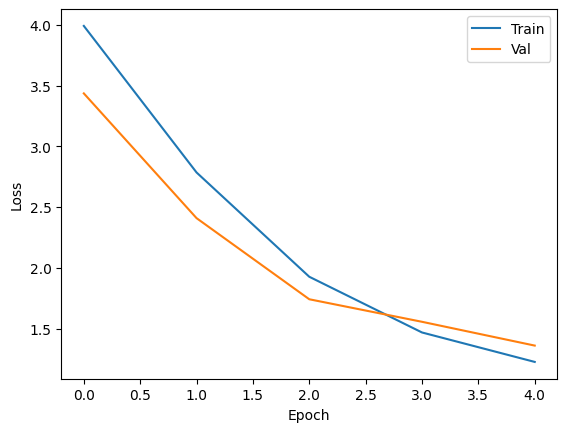

In [ ]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Инференс

In [ ]:
def inference(encoder, decoder, image_path, max_len=150):
    encoder.eval()
    decoder.eval()
    image = Image.open(image_path)
    bbox = image.getbbox()
    if bbox:
        image = image.crop(bbox).convert('L')
        w, h = image.size
        image = image.resize((w // 2, h // 2), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = encoder(image)
        batch_size = 1
        h, c = torch.zeros(batch_size, hidden).to(device), torch.zeros(batch_size, hidden).to(device)
        o = torch.zeros(batch_size, hidden).to(device)
        y = torch.LongTensor([[sos_id]]).to(device)
        result = []
        for _ in range(max_len):
            embed = decoder.embed(y.squeeze(1))
            inp = torch.cat((embed, o), dim=1)
            h, c = decoder.lstm(inp, (h, c))
            context = decoder.attn(h, features)
            out = torch.tanh(decoder.fc_out(torch.cat((h, context), dim=1)))
            o = out
            pred = decoder.fc(out)
            y = pred.argmax(1).unsqueeze(1)
            if y.item() == eos_id:
                break
            result.append(y.item())
    return sp.decode_ids(result)

In [ ]:
create_filter_list('data/im2latex_test.lst', 'data/test_filter64.lst', 'data/images_processed', 'data/im2latex_formulas.norm.lst', min_height=64, min_width=64, filter_on=True)

[INFO] Файл data/im2latex_formulas.norm.lst открыт в кодировке: Windows-1252


100%|██████████| 10355/10355 [00:01<00:00, 5263.17it/s]


In [ ]:
# Загрузка отфильтрованного списка тестовых данных
test_items = read_split_list('data/test_filter64.lst')

In [ ]:
# Выбор конкретного изображения (например, первого из списка)
if test_items:
    # Берем первый элемент из тестового набора
    idx, img_name, rtype = test_items[0]

    # Формируем путь к изображению
    image_path = os.path.join('data/images_processed', img_name)

    # Получаем истинную формулу для сравнения
    true_formula = FORMULAS[idx]
    print(f"True formula: {true_formula}")

    # Запускаем инференс
    predicted_formula = inference(encoder, decoder, image_path)
    print(f"Predicted formula: {predicted_formula}")

True formula: \left\{\begin{array}{c}	\partial_{\tau}R+\vec\nabla\cdot	\left(\vec\nabla\Theta\,\sqrt{\displaystyle\frac{R^2+a^2}	{1+(\vec\nabla\Theta)^2}}\right)=0,\hfill\\m]	\partial_{\tau}\Theta+R\sqrt{	\displaystyle\frac{1+(\vec\nabla\Theta)^2}	{R^2+a^2}}=0.\hfill\\     \end{array}\right.     \label{JPeqmot}
Predicted formula: \left[ \begin{array}{l}\left[ \stackrel{\scriptstyle{a,R+5}^{\infty }\left|\prod_{i\neq j}^{\prime }\prod\limits_{i\neq j}^{\prime }\left|\prod_{i\neq j}^{\prime }\right)^{\frac{1}{r\neq 0}\right)^{\frac{1}{p-p})^{2}}\left[\prod_{i\neq j}^{j+p-p}\right)^{\frac{1}{p-p})^{2})^{\frac{1}{p-p})^{\frac{1}{p-p})^{\frac{1}{p-p})^{\frac{1}{p-p})^{\frac{1}{p-p})^{\frac


# Итог

Видно, что модель начала понимать некоторые стартовые токены. 5 эпох обучения заняли около часа, но заметна хорошая тенденция в уменьшении потерь. небольшой период обучения выбран для демонстрации работоспособности модели и ее графиков оубчения. Для более качественного обучения может понадобиться гораздо большее число эпох обучения.